# 코드로 인해 구현해보기

In [ ]:
# KoBERT fine tuning 할 수 있는 버전 가져오기
# Github 업로드 시 줄이 불필요하게 길어질 부분 주석 처리

# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
# KoBERT Fine-Tuning에 필요한 패키지 import

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm


# kobert
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

from transformers import AdamW # 모델의 초기값 지정 함수를 아담으로 설정.
from transformers.optimization import get_cosine_schedule_with_warmup

import pandas as pd

In [1]:
# Colab 환경에서 진행하기 때문에 google drive 연결

from google.colab import drive

drive.mount('/content/drive')

# GPU 사용.
device = torch.device("cuda:0") 
# device = torch.device("cpu")

Mounted at /content/drive


In [ ]:
import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


In [ ]:
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.10.1+cu102
cuda version: 10.2
cudnn version:7605


In [ ]:
def sentiment_analysis(data):
  if data == 'negative':
    return 0
  elif data == 'neutral':
    return 1
  else:
    return 2

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Deep_Learning/NLP/finance_sentiment_corpus-main/finance_data.csv',encoding='utf-8-sig')

# negative 0, neutral 1, positive 2,

data['labels_tr'] = data['labels'].apply(lambda x: sentiment_analysis(x))
data = data[['kor_sentence','labels_tr']]
data = [[i, str(j)] for i, j in zip(data['kor_sentence'], data['labels_tr'])]

bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# 토큰화

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
## Setting parameters

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int64(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data, test_size = 0.2, random_state=0)


data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=1)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/61 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.1965053081512451 train acc 0.234375
epoch 1 train acc 0.6097165300546449


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 1 test acc 0.794140625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.49946004152297974 train acc 0.765625
epoch 2 train acc 0.8161714480874317


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 2 test acc 0.8142578125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.3411124050617218 train acc 0.90625
epoch 3 train acc 0.8890027322404371


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 3 test acc 0.8123046875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.17106139659881592 train acc 0.96875
epoch 4 train acc 0.9259733606557377


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 4 test acc 0.8390625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.1358284205198288 train acc 0.953125
epoch 5 train acc 0.9626024590163934


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 5 test acc 0.8396484375


In [ ]:
torch.save(model, f'/content/drive/MyDrive/SentimentAnalysisKOBert.pt')
torch.save(model.state_dict(), f'/content/drive/MyDrive/SentimentAnalysisKOBert_StateDict.pt')

In [3]:
import pandas as pd
from tqdm import tqdm, tqdm_notebook

In [ ]:
def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

def testModel(model, seq):
    cate = ["부정","중립","긍정"]
    tmp = [seq]
    transform = nlp.data.BERTSentenceTransform(tok, max_len, pad=True, pair=False)
    tokenized = transform(tmp)

    model.eval()
    result = model(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
    idx = result.argmax().cpu().item()
    return cate[idx]

In [ ]:
pred_data = pd.read_csv('/content/drive/MyDrive/Deep_Learning/NLP/final_df_kr.csv',encoding='utf-8-sig')
pred_data = pred_data[['기업명','기사_내용']]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
pred_data['sentiment'] = pred_data['기사_내용'].apply(lambda x: testModel(model, x))

In [ ]:
# 감성 분석한 값 저장.

# pred_data.to_csv('/content/drive/MyDrive/pred_data_0213.csv',encoding='utf-8-sig')

In [4]:
pred_data = pd.read_csv('/content/drive/MyDrive/pred_data_0213.csv',index_col=0)

In [5]:
pred_data['sentiment'] = pred_data['sentiment'].apply(lambda x: 1 if x == '긍정' else 0 if x == '중립' else -1)
pred_data['sentiment'].value_counts()

 0    39932
 1    33524
-1    16186
Name: sentiment, dtype: int64

In [6]:
df_groupby = pred_data.groupby('기업명')[['sentiment']].sum().reset_index()
df_groupby.head()

,기업명,sentiment
0,1017호 (마곡동,0
1,ING생명보험,43
2,KG이티에스,16
3,LG에너지솔루션,476
4,NH올원리츠,11


In [15]:
df_ipo = pd.read_csv('/content/drive/MyDrive/final_df_1115.csv',encoding='cp949',index_col=0)

In [16]:
df_ipo.columns

Index(['Unnamed: 0.1', '기업명', '시장구분', '업종', '매출액', '순이익', '자본금', '종목코드',
       '기업구분', '확정공모가', '주간사', '수요예측일', '공모청약일', '상장일', '기관경쟁률', '의무보유확약',
       '감정', '첫날종가(원)', 'firstday_return', 'c_pos', 'c_neg', 'c_neu', 'v_pos',
       'v_neg', 'v_neu', 'close_price_1', 'close_price_2', 'close_price_3',
       'close_price_4', 'close_price_5', 'close_price_6', 'close_price_7',
       'twoday_return', 'threeday_return', 'fourday_return', 'fiveday_return',
       'sixday_return', 'sevenday_return', 'c_senti_analysis',
       'v_senti_analysis', 'mod', 'c_pos_rate', 'c_neg_rate', 'v_pos_rate',
       'v_neg_rate'],
      dtype='object')

In [18]:
del df_ipo['Unnamed: 0.1']

In [30]:
final_df = pd.merge(df_ipo,df_groupby, how='left',on='기업명')
final_df.dropna(subset=['sentiment'],inplace=True)
final_df.reset_index(drop=True,inplace=True)

In [28]:
final_df.head()

,기업명,시장구분,업종,매출액,순이익,자본금,종목코드,기업구분,확정공모가,주간사,...,sixday_return,sevenday_return,c_senti_analysis,v_senti_analysis,mod,c_pos_rate,c_neg_rate,v_pos_rate,v_neg_rate,sentiment
0,스코넥,코스닥,소프트웨어 개발 및 공급업,4558,-8971,6036,276040,중소일반,13000,신영증권,...,107.692308,81.153846,25.245902,24.255319,612.347402,6.065418,3.620197,4.016506,2.448418,23.0
1,이지트로닉스,코스닥,"전동기, 발전기 및 전기 변환 공급 제어 장치",15349,3552,3982,377330,중소일반,22000,NH투자증권,...,-13.181818,-21.590909,32.624113,20.192308,658.756138,5.982086,3.039028,4.189008,2.781501,14.0
2,케이티비네트워크,코스닥,기타 금융업,66974,35765,50000,298870,중소일반,5800,"한국투자증권,NH투자증권,삼성증권,유진투자증권,하이투자증권,KB증권",...,-8.793103,-8.793103,65.217391,40.000000,2608.695652,0.662714,0.139519,3.753351,1.608579,2.0
3,피코그램,코스닥,기타 제품 제조업,24273,1957,306,376180,중소일반,12500,IBK투자증권,...,35.200000,35.600000,44.444444,20.512821,911.680911,0.902778,0.347222,4.900938,3.232534,7.0
4,엔켐,코스닥,기초 화학물질 제조업,138888,501,7553,348370,중소일반,42000,"대신증권,신한금융투자",...,105.238095,116.666667,67.713004,16.883117,1143.206569,6.097163,1.173785,3.245582,2.307970,33.0


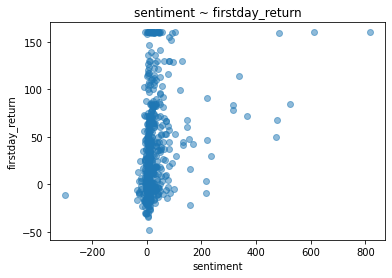

In [31]:
X = final_df.sentiment.values
Y = final_df.firstday_return.values

import matplotlib.pyplot as plt

plt.scatter(X, Y, alpha=0.5)

plt.title('sentiment ~ firstday_return')
plt.xlabel('sentiment')
plt.ylabel('firstday_return')
plt.show()

In [32]:
import scipy.stats as stats
stats.pearsonr(X,Y)

(0.2531189633197248, 2.51943713210262e-09)

In [33]:
from statsmodels.formula.api import ols

res = ols('firstday_return ~ sentiment+순이익+자본금+매출액+시장구분+기관경쟁률+의무보유확약',data=final_df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        firstday_return   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     36.83
Date:                Wed, 15 Feb 2023   Prob (F-statistic):           1.94e-46
Time:                        01:43:10   Log-Likelihood:                -2772.6
No. Observations:                 539   AIC:                             5563.
Df Residuals:                     530   BIC:                             5602.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1092      6.279      0.017      0.986     -12.226      12.444
시장구분[T.유가증권]    40.6592     42.265      0.962      0.336     -42.369     123.687
시장구분[T.코스닥]      5.2449      6.214      0.844      0.399      -6.962      17.452
sentiment        0.0783      0.029      2.743      0.006       0.022       0.134
순이익          -4.583e-06   1.97e-05     -0.233      0.816   -4.32e-05     3.4e-05
자본금          -2.231e-05   1.69e-05     -1.322      0.187   -5.55e-05    1.08e-05
매출액           -2.91e-06   3.06e-06     -0.952      0.342   -8.92e-06     3.1e-06
기관경쟁률            0.0411      0.004     10.931      0.000       0.034       0.049
의무보유확약           0.7342      0.124      5.944      0.000       0.492       0.977
==============================================================================
Omnibus:                       32.077   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.811
Skew:                           0.640   Prob(JB):                     1.02e-08
Kurtosis:                       2.976   Cond. No.                     1.65e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Ko-Bert를 활용한 감성 분석
- Ko-Bert fine-tuning한 모델을 졸업 논문에서 활용한 IPO 데이터에 적용했을 때 감성 분석 값은 IPO 초기수익률에 유의미한 영향을 미치는 것을 확인할 수 있었음.
- 뉴스 기사의 감성이 긍정인 뉴스 기사가 1개씩 증가할 때 마다, IPO 초기수익률은 0.07%만큼 증가함.